In [106]:
# Import necessary packages
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
torch.cuda.device_count()  # print 1
import torchdeepretina as tdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchdeepretina.io as tdrio
import torchdeepretina.utils as tdrutils
import stimuli as s
import torchdeepretina.stimuli as tdrstim
from tqdm import tqdm
from itertools import repeat
from matplotlib import ticker, cm
! pip install MulticoreTSNE

/home/htanaka/TorchRetina/lib/python3.5/site-packages/OpenSSL/crypto.py:14: CryptographyDeprecationWarning: Python 3.5 support will be dropped in the next release of cryptography. Please upgrade your Python.
  from cryptography import utils, x509
You should consider upgrading via the 'pip install --upgrade pip' command.


In [107]:
device = torch.device("cuda:0")

# load model given path
def load_model(model_path):
    """
    in: model_path
    out: model
    """
    model = tdrio.load_model(model_path)
    model.to(device)
    model.eval()
    return model

model_dir_path = '/home/htanaka/torch-deep-retina/models_paper/'#/tanaka/convgc_models/gcchansearch_57_chans[4, 4]/'

n_chans=17
model_n_path = 'convgc_15-11-21b_naturalscene'
#model_n_path = 'convgc_15-10-07_naturalscene'
#model_n_path = '15-11-21b_naturalscene.pt'

model_n = load_model(model_dir_path + model_n_path + '.pt')
model_n = tdr.utils.stacked2conv(model_n)

# model_w_path = 'convgc_15-11-21b_whitenoise.pt'
# model_w = load_model(model_dir_path + model_w_path)
# model_w = tdr.utils.stacked2conv(model_w)


# OSR
def OSR(period):
    duration = 100
    x_=np.zeros([duration+40,50,50])
    idxs =(89-np.arange(0,90, period))[::-1]
    indices = np.sort(np.concatenate([idxs, idxs+1]))
    x_[indices]-=2
    x=np.zeros([duration,40,50,50])
    for i in range(duration):
        x[i]=x_[i:i+40]
    return x
x = OSR(10)
x.shape

# Latency coding
def SinglePulse(intensity=2, duration=40):
    X_=np.zeros([duration+40,50,50])
    indices = 40
    X_[indices:]-=intensity
    X=np.zeros([duration,40,50,50])
    for i in range(duration):
        X[i]=X_[i:i+40]
    return X


# Motion anticipation
def motion_anticipation(velocity=0.08, width=6, flash_duration=2, filt_depth=40):
    c_right, speed_right, stim_right = tdrstim.driftingbar(velocity,    
                                                 width, x=(-30, 30))    
    rightward_moving_bar = torch.from_numpy(stim_right)
    c_left, speed_left, stim_left = tdrstim.driftingbar(-velocity,      
                                               width, x=(30, -30))      
    leftward_moving_bar = torch.from_numpy(stim_left)
    flash_centers = np.arange(-25, 26)
    flashes = (tdrstim.flash(flash_duration, 43, 70,                    
                        intensity=tdrstim.bar((x, 0), width, 50)) for x in flash_centers)
    xs = []
    for f in flashes:
        x = torch.from_numpy(tdrstim.concat(f, nh=filt_depth))
        xs.append(x)
    return xs, rightward_moving_bar, c_right, leftward_moving_bar, c_left





# Motion reversal
def run_motion_reversal(x_locations=np.arange(-9, 3), speed=0.19, clip_n=210, scaling=1):
    """Gets responses to a bar reversing motion."""                        
    tflips, Xs = zip(*[s.motion_reversal(xi,speed)[1:] for xi in x_locations])
    return tflips, Xs


def plot_integrad(integrad):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    # Set line width of axes
    ax.spines["top"].set_linewidth(0)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["right"].set_linewidth(0)
    ax.spines["left"].set_linewidth(2)

    # Turn on/off axes, ticks, change width, labelsize
    ax.tick_params(axis="both", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.0,pad=8,labelsize=20)
    plt.xlabel('$t$[s]', size=20)
    plt.ylabel('Rate [Hz]', size=20)
    
    # Plot the response of an output neuron
    plt.plot( integrad[1] , lw=3, c=plt.cm.tab10(7), linestyle='--')
    # Plot the decomposed contributions of first layer cell-tyeps
    plt.plot( torch.sum(integrad[0], axis=(2,3))[:,:] , lw=3 )
    
    #plt.title('period: '+str(period)+', peak timing: '+str(np.argmax(integrad[1].cpu().detach().numpy())), fontsize=20)
    plt.legend(fontsize=18, title='Channel')
    fig.tight_layout()
    return


def imshow_integrad(integrad):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    # Set line width of axes
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)

    # Turn on/off axes, ticks, change width, labelsize
    ax.tick_params(axis="both", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.0,pad=8,labelsize=20)
    plt.xlabel('$t$[s]', size=20)
    plt.ylabel('Channels', size=20)

    plt.imshow(torch.sum(integrad[0], axis=(2,3)).T, aspect='auto', cmap='bwr', vmin=-2, vmax=2)
    fig.tight_layout()
    return

In [108]:
# Import packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import h5py

# These are the "Tableau 10" colors as RGB.    
tableau10 = [(31,119,180),(44,160,44),(255,127,14),(214,39,40),(148,103,189),(140,86,75),(227,119,194),(127,127,127),(188,189,34),(23,190,207)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau10)):    
    r, g, b = tableau10[i]    
    tableau10[i] = np.array([r / 255., g / 255., b / 255.]) 
    
    
# Load h5 data files: IntegratedGradient calculated over channels
n1 = h5py.File('/home/htanaka/torch-deep-retina/convgc_15-11-21b_naturalscene_stim_naturalscene_layer1_step20.h5', 'r')
w1 = h5py.File('/home/htanaka/torch-deep-retina/convgc_15-11-21b_whitenoise_stim_naturalscene_layer1_step20.h5', 'r')

# Create numpy array with the integrated gradients, and output (ganglion cell) activations
IG_n1 = np.asarray(n1['intg_grad'])
gc_act_n1 = np.asarray(n1['gc_activs'])

IG_w1 = np.asarray(w1['intg_grad'])
gc_act_w1 = np.asarray(w1['gc_activs'])

# Close h5 files
n1.close()
w1.close()

# Take out specific integrated gradients computed for an output neuron number 6
IG_n = IG_n1[:,6,:]
IG_w = IG_w1[:,6,:]

act_n= gc_act_n1[:,6]
act_w= gc_act_w1[:,6]

5139


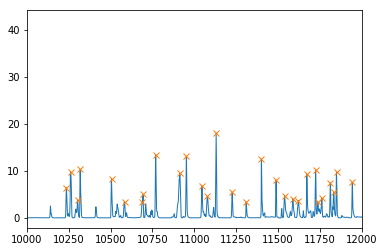

23374


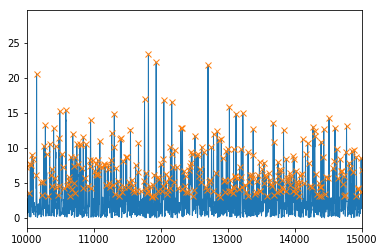

In [109]:
delay=0
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
threshold_n = 3#1.5
threshold_w = 3#1.5#5.8



# Copy the array: activation_3
act_n_copy=np.copy(act_n)
# Set activation below threshold to be 0. This is to avoid picking up tiny peaks
act_n_copy[np.where(act_n_copy<threshold_n)]=0
# Detect peaks
peaks_n, _ = find_peaks(act_n_copy, distance=5)
peaks_n=peaks_n[:-5] + delay

plt.plot(act_n, lw=1)
plt.plot(peaks_n, act_n[peaks_n], "x", lw=0)

plt.xlim(10000,12000)
print(len(peaks_n))
plt.show()



# Copy the array: activation_3
act_w_copy=np.copy(act_w)
# Set activation below threshold below 10 to be 0. This is to avoid picking up tiny peaks
act_w_copy[np.where(act_w_copy<threshold_w)]=0
# Detect peaks
peaks_w, _ = find_peaks(act_w_copy, distance=5)
peaks_w=peaks_w[:-5] + delay

plt.plot(act_w, lw=1)
plt.plot(peaks_w, act_w[peaks_w], "x", lw=0)

plt.xlim(10000,15000)
print(len(peaks_w))
plt.show()

In [110]:
# Latency coding
integ_steps = 100
latency_cells = [6]
intensities = np.arange(1.2,2.0,0.1)

IG_latency = np.zeros([len(intensities),8])

response = np.zeros(40)
ex_integrad = np.zeros(40)
in_integrad = np.zeros(40)

for i in range( len(intensities) ):
    for j in latency_cells:
        outfile_integrad = './analysis_data/'+model_n_path+'/latency_coding/integrad_chan_'+str(j)+'_intensity_'+str(np.round_(intensities[i],decimals=1))+'_steps_'+str(integ_steps)+'.npy'
        outfile_response = './analysis_data/'+model_n_path+'/latency_coding/response_chan_'+str(j)+'_intensity_'+str(np.round_(intensities[i],decimals=1))+'_steps_'+str(integ_steps)+'.npy'

        response += np.load(outfile_response)[:,0]
        integrad = np.load(outfile_integrad)
        IG_latency[i] = np.sum(integrad,axis=(2,3))[np.argmax(response)]
        

In [111]:
# OSR
periods = np.arange(2,9)
contribs = np.zeros([n_chans,len(periods), 8])
att_periodic=np.zeros(8)
att_violation=np.zeros(8)
frac_array  = np.zeros( [len(periods),n_chans] )

IG_osr = np.zeros([len(periods),8])

osr_cells = [6]
for j in osr_cells:
    for i in range( len(periods) ):
        outfile_integrad = './analysis_data/'+model_n_path+'/osr/integrad_chan_'+str(j)+'_period_'+str(periods[i])+'_steps_'+str(integ_steps)+'.npy'
        outfile_response = './analysis_data/'+model_n_path+'/osr/response_chan_'+str(j)+'_period_'+str(periods[i])+'_steps_'+str(integ_steps)+'.npy'
        response = np.load(outfile_response)
        peak = 60+np.argmax(response[60:])
        integrad = np.load(outfile_integrad)
        IG_osr[i] = np.sum(integrad,axis=(2,3))[60+np.argmax(response[60:])]

In [112]:
# Motion anticipation

# Data generation
#flash, rightward_moving_bar, c_right, leftward_moving_bar, c_left = motion_anticipation(velocity=0.176, width=2, flash_duration=2, filt_depth=40)
flash, rightward_moving_bar, c_right, leftward_moving_bar, c_left = motion_anticipation(velocity=0.08, width=4, flash_duration=2, filt_depth=40)

from colormap import Colormap
c = Colormap()
mycmap = c.cmap_linear('#2378FF','#FFFFFF','#FF3C3C')
integ_steps = 100

IG_mr = np.zeros([len(np.arange(8,12)),8])

# loop over output ganglion cells
j=6
# read integrated_gradients, response files
integrad_file_r = './analysis_data/'+model_n_path+'/motion_anticipation/integrad_r_chan_'+str(j)+'_steps_'+str(integ_steps)+'.npy'
response_file_r = './analysis_data/'+model_n_path+'/motion_anticipation/response_r_chan_'+str(j)+'_steps_'+str(integ_steps)+'.npy'
integrad_file_l = './analysis_data/'+model_n_path+'/motion_anticipation/integrad_l_chan_'+str(j)+'_steps_'+str(integ_steps)+'.npy'
response_file_l = './analysis_data/'+model_n_path+'/motion_anticipation/response_l_chan_'+str(j)+'_steps_'+str(integ_steps)+'.npy'

IG_r = np.load(integrad_file_r) 
R_r  = np.load(response_file_r)
IG_l = np.load(integrad_file_l) 
R_l  = np.load(response_file_l)

IG_ma = np.zeros([2,8])

IG_ma[0] = np.sum(IG_r, axis=(2,3))[np.argmax(R_r)]
IG_ma[1] = np.sum(IG_r, axis=(2,3))[np.argmax(R_l)]



In [250]:
# Contrast adaptation
def filter_and_nonlinearity(model, contrast,layer_name='sequential.0',
                                              unit_index=(0,15,15),
                                              #nonlinearity_type='bin',
                                              #filt_depth=40, #sta=None,
                                              #batch_size=2000,
                                              n_samples=100,
                                              verbose=False):
    """
    Creates a filter and a nonlinearity fit to the model output at the
    specified layer. Used to evaluate the internal cells of the model.

    contrast: float
        intensity (std) of stimulus for fitting filter and
        nonlinearity
    layer_name: str
        the name of the layer of interest
    unit_index: tuple of ints (channel, row, col)
        the index of the unit of interest within the layer.
    nonlinearity_type: str
        the type of nonlinearity to be fit
    filt_depth: int
        the depth of the stimulus for each sample
    sta: ndarray (C,H,W)
        a premade spike triggered average
    batch_size: int
        the size of the batches used for computing the filter
    n_samples: int
        the number of samples to use when fitting the filter
    """
    # Computing STA
    stimulus = tdrstim.repeat_white(n_samples,nx=model.img_shape[1],
                                                  contrast=contrast,
                                                  n_repeats=3)
    stimulus = tdrstim.rolling_window(stimulus, model.img_shape[0])
    intg, resp = tdrutils.integrated_gradient(model=model, X=stimulus, layer="sequential.0", chans=6, alpha_steps=100)
    
    return intg, resp

IG_ca = np.zeros([2,8])
# high contrast = 1.2, low contrast = 0.5
intg, resp = filter_and_nonlinearity(model=model_n, contrast=1.2,layer_name='sequential.0',
                                              unit_index=(0,15,15),
                                              n_samples=100,
                                              verbose=False)
intg = intg.cpu().numpy()
IG_ca[0] = np.sum(intg,axis=(2,3))[np.argmax(np.sum(intg,axis=(1,2,3)))]
intg, resp = filter_and_nonlinearity(model=model_n, contrast=0.5,layer_name='sequential.0',
                                              unit_index=(0,15,15),
                                              n_samples=100,
                                              verbose=False)
intg = intg.cpu().numpy()
IG_ca[1] = np.sum(intg,axis=(2,3))[np.argmax(np.sum(intg,axis=(1,2,3)))]

In [221]:
path_to_data = '/home/grantsrb/deep_retina_data'
# Load the Data
dataset = "15-10-07"
cells = "all"
stim_type = "naturalscene"
bsize = 1000
#props_fname = "polarity_rev/{}polarity_reversals.p".format(prename)
dsets = [ "15-10-07", "15-11-21a", "15-11-21b", ]
stypes = ["naturalscene", "whitenoise"]
#prename = "convgc_"
#prepath = '/home/grantsrb/src/torch-deep-retina/models/'
savefolder = "FigureUpdates_March2023/"
caption_file = "caption.txt"
nat_color = 'lightcoral'

test_data = tdr.datas.loadexpt(dataset, cells, stim_type, 'test',
                                     40, nskip=0,
                                     data_path=path_to_data)
#torch.FloatTensor(test_data.X)
inst_rfs = tdr.utils.get_stim_grad(model_n, torch.FloatTensor(test_data.X), "output", 6, to_numpy=True)
mean_rf = inst_rfs.mean(0)
prods = np.dot(mean_rf.reshape(-1), inst_rfs.reshape(len(inst_rfs),-1).T).T
polar_reverse_stim = test_data.X[prods<0]
no_polar_reverse_stim = test_data.X[prods>0][:596]

IG_pr = np.zeros([2,8])
intg, resp = tdrutils.integrated_gradient(model=model_n, X=polar_reverse_stim, layer="sequential.0", chans=6, alpha_steps=100)
IG_pr[0] = np.sum(intg.cpu().numpy(), axis=(2,3))[np.argmax(resp.cpu().numpy())]

intg, resp = tdrutils.integrated_gradient(model=model_n, X=no_polar_reverse_stim, layer="sequential.0", chans=6, alpha_steps=100)
IG_pr[1] = np.sum(intg.cpu().numpy(), axis=(2,3))[np.argmax(resp.cpu().numpy())]



  0%|          | 0/11 [00:00<?, ?it/s]

layer: output
hook attached to sequential.11




  9%|▉         | 1/11 [00:00<00:04,  2.17it/s]

 18%|█▊        | 2/11 [00:01<00:04,  1.91it/s]

 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

 55%|█████▍    | 6/11 [00:04<00:03,  1.48it/s]

 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

 73%|███████▎  | 8/11 [00:05<00:02,  1.47it/s]

 82%|████████▏ | 9/11 [00:06<00:01,  1.48it/s]

 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

100%|██████████| 11/11 [00:07<00:00,  1.45it/s]

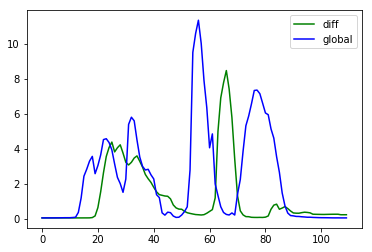

In [115]:
def oms_random_differential(model, duration=5, sample_rate=30,
                                               pre_frames=40,
                                               post_frames=40,
                                               img_shape=(50,50),
                                               center=(25,25),
                                               radius=8,
                                               background_velocity=.3,
                                               foreground_velocity=.5,
                                               seed=None, bar_width=4,
                                               inner_bar_width=None,
                                               filt_depth=40):
    """
    Plays a video of differential motion by keeping a circular window
    fixed in space on a 2d background grating. A grating exists behind
    the circular window that moves counter to the background grating.
    Each grating is jittered randomly.

    duration: float
        length of video in seconds
    sample_rate: float
        sample rate of video in frames per second
    pre_frames: int
        number of frames of still image to be prepended to the
        jittering
    post_frames: int
        number of frames of still image to be appended to the
        jittering
    img_shape: sequence of ints len 2
        the image size (H,W)
    center: sequence of ints len 2
        the starting pixel coordinates of the circular window
        (0,0 is the upper left most pixel)
    radius: float
        the radius of the circular window
    background_velocity: float
        the intensity of the horizontal jittering of the background
        grating
    foreground_velocity: float
        the intensity of the horizontal jittering of the foreground
        grating
    seed: int or None
        sets the numpy random seed if int
    bar_width: int
        size of stripes. Min value is 3
    inner_bar_width: int
        size of grating bars inside circle. If None, set to bar_width
    """
    if seed is not None:
        np.random.seed(seed)
    tot_frames = int(duration * sample_rate)
    diff_frames = int(tot_frames-pre_frames-post_frames)
    assert diff_frames > 0
    differential,_,_ = tdrstim.random_differential_circle(diff_frames,
                              bar_width=bar_width,
                              inner_bar_width=inner_bar_width,
                              foreground_velocity=foreground_velocity,
                              background_velocity=background_velocity,
                              image_shape=img_shape,
                              center=center, radius=radius) 
    pre_vid = np.repeat(differential[:1], pre_frames, axis=0)
    post_vid = np.repeat(differential[-1:], post_frames, axis=0)
    diff_vid =np.concatenate([pre_vid,differential,post_vid], axis=0)

    global_velocity = foreground_velocity if foreground_velocity != 0\
                                              else background_velocity
    global_, _, _ = tdrstim.random_differential_circle(diff_frames,
                                 bar_width=bar_width,
                                 inner_bar_width=inner_bar_width,
                                 foreground_velocity=global_velocity,
                                 sync_jitters=True,
                                 background_velocity=global_velocity,
                                 image_shape=img_shape, center=center,
                                 radius=radius, 
                                 horizontal_foreground=False,
                                 horizontal_background=False)
    pre_vid = np.repeat(global_[:1], pre_frames, axis=0)
    post_vid = np.repeat(global_[-1:], post_frames, axis=0)
    global_vid = np.concatenate([pre_vid, global_, post_vid], axis=0)
    if model is None:
        fig = None
        diff_response = None
        global_response = None
    else:
        x = torch.FloatTensor(tdrstim.rolling_window(diff_vid,
                                                     filt_depth))
        x = x.to(device)
        with torch.no_grad():
            if model.recurrent:
                hs = [torch.zeros(1,*h).to(device) for h in\
                                                model.h_shapes]
                resps = []
                for i in range(x.shape[0]):
                    resp, hs = model(x[i:i+1], hs)
                    resps.append(resp)
                resp = torch.cat(resps, dim=0)
            else:
                #resp = model(x)
                intg, resp = tdrutils.integrated_gradient(model=model_n, X=x.cpu(), layer="sequential.0", chans=6, alpha_steps=100)
        diff_response = resp.cpu().detach().numpy()
        diff_intg = intg.cpu().detach().numpy()

        x = tdrstim.rolling_window(global_vid, filt_depth)
        x = torch.FloatTensor(x).to(device)
        with torch.no_grad():
            if model.recurrent:
                hs = [torch.zeros(1,*h).to(device) for h in\
                                                    model.h_shapes]
                resps = []
                for i in range(x.shape[0]):
                    resp, hs = model(x[i:i+1], hs)
                    resps.append(resp)
                resp = torch.cat(resps, dim=0)
            else:
                #resp = model(x)
                intg, resp = tdrutils.integrated_gradient(model=model_n, X=x.cpu(), layer="sequential.0", chans=6, alpha_steps=100)
        global_response = resp.cpu().detach().numpy()
        global_intg = intg.cpu().detach().numpy()
        #global_response = resp.cpu().detach().numpy()

        # generate the figure
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(111)
        ax.plot(diff_response.mean(-1), color="g")
        ax.plot(global_response.mean(-1), color="b")
        ax.legend(["diff", "global"])
        s = np.s_[pre_frames-40:tot_frames-post_frames]
        diff_response = diff_response[s]
        global_response = global_response[s]
    return fig, diff_vid, global_vid, diff_response, global_response, diff_intg, global_intg

filt_depth = model_n.img_shape[0]
tup = oms_random_differential(model_n, filt_depth=filt_depth)
fig, _, _, diff_response, global_response, diff_intg, global_intg = tup

IG_oms = np.zeros([2,8])
IG_oms[0] = np.sum(global_intg, axis=(2,3))[np.argmax(global_response)]
IG_oms[1] = np.sum(diff_intg, axis=(2,3))[np.argmax(diff_response)]


In [281]:
from scipy.fftpack import fft, fftshift, fftfreq
import torch # Add this import

def freq_doubling(predict, ncells, phases, widths, halfperiod=25, nsamples=140, filt_depth=40):
    F1 = np.zeros((ncells, phases.size, widths.size))
    F2 = np.zeros_like(F1)

    period = (2 * halfperiod) * 0.01
    base_freq = 1 / period
    freqs = fftfreq(nsamples - filt_depth, 0.01)
    i1 = np.where(freqs == base_freq)[0][0]
    i2 = np.where(freqs == base_freq * 2)[0][0]

    for p, phase in enumerate(phases):
        #for w, width in tqdm(list(enumerate(widths))):
        w=1
        width=widths[1]
        X = tdrstim.reversing_grating(nsamples, halfperiod, width, phase, 'sin')
        stim = tdrstim.concat(X)
        # Convert numpy array to PyTorch tensor
        model_device = next(predict.parameters()).device # Get the device of the model's weights
        stim_tensor = torch.from_numpy(stim).float().to(model_device) # Move tensor to the same device as the model's weights
        #r = predict(stim_tensor) # Pass tensor instead of numpy array
        intg, r = tdrutils.integrated_gradient(model=model_n, X=stim_tensor.cpu(), layer="sequential.0", chans=6, alpha_steps=100)
        for ci in range(r.shape[1]):
            r_numpy = r[:, ci].detach().cpu().numpy() # Convert tensor to numpy array
            amp = np.abs(fft(r_numpy))
            F1[ci, p, w] = amp[i1]
            F2[ci, p, w] = amp[i2]
    return F1, F2, X, stim, intg, r

phases = np.linspace(0, 1, 9)       # Grating phases.
widths = np.arange(1, 9)            # Bar widths (checkers).
F1, F2, X, stim, intg, resp = freq_doubling(model_n, ncells=17, phases=phases, widths=widths, halfperiod=25, nsamples=140, filt_depth=40)

IG_fd = np.zeros([1,8])
IG_fd[0] = np.sum(intg.cpu().numpy(), axis=(2,3))[np.argmax( np.sum(intg.cpu().numpy(), axis=(1,2,3)) )]
#IG_fd[0], resp = tdrutils.integrated_gradient(model=model_n, X=stim, layer="sequential.0", chans=6, alpha_steps=100)
#X.shape

max_index = np.unravel_index(np.argmax(F2), F2.shape)
max_width = widths[max_index[2]]
print(max_width)


shape of X: (10304, 5)


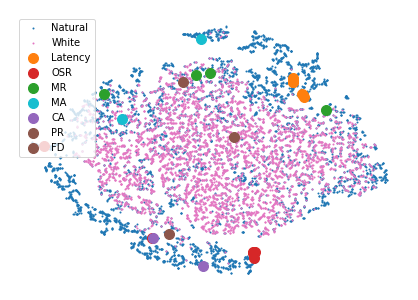

In [229]:
# Data generation
#flash, rightward_moving_bar, c_right, leftward_moving_bar, c_left = motion_anticipation(velocity=0.176, width=2, flash_duration=2, filt_depth=40)
flash, rightward_moving_bar, c_right, leftward_moving_bar, c_left = motion_anticipation(velocity=0.08, width=4, flash_duration=2, filt_depth=40)


# Motion reversal
from colormap import Colormap
c = Colormap()
mycmap = c.cmap_linear('#2378FF','#FFFFFF','#FF3C3C')
integ_steps = 100

IG_mr = np.zeros([len(np.arange(8,12)),8])

# loop over output ganglion cells
for j in [6]:
    # read integrated_gradients, response files
    integrad_file_r = './analysis_data/'+model_n_path+'/motion_anticipation/integrad_r_chan_'+str(j)+'_steps_'+str(integ_steps)+'.npy'
    response_file_r = './analysis_data/'+model_n_path+'/motion_anticipation/response_r_chan_'+str(j)+'_steps_'+str(integ_steps)+'.npy'
    integrad_file_l = './analysis_data/'+model_n_path+'/motion_anticipation/integrad_l_chan_'+str(j)+'_steps_'+str(integ_steps)+'.npy'
    response_file_l = './analysis_data/'+model_n_path+'/motion_anticipation/response_l_chan_'+str(j)+'_steps_'+str(integ_steps)+'.npy'
    
    IG_r = np.load(integrad_file_r) 
    R_r  = np.load(response_file_r)
    IG_l = np.load(integrad_file_l) 
    R_l  = np.load(response_file_l)
        
    # determine peaks of response induced by a bar moving left/right 
    peak_r = c_right[40:][np.argmax(R_r)]
    peak_l = c_left[40:][np.argmax(R_l)] 
    # compute the location of the center of the receptive field and round the value
    recep_field_center = (peak_r+peak_l)/2
    locations = np.arange(recep_field_center-6, recep_field_center+6)
    integ_steps = 100


    #plt.title(j)
    tflips, Xs = run_motion_reversal(x_locations=locations, speed=0.19, clip_n=210, scaling=1)
    for n, i in enumerate(np.arange(8,12)):
        x  = Xs[i]

        outfile_integrad = './analysis_data/'+model_n_path+'/motion_reversal/integrad_chan_'+str(j)+'_locations_'+str(locations[i])+'_steps_'+str(integ_steps)+'_.npy'
        outfile_response = './analysis_data/'+model_n_path+'/motion_reversal/response_chan_'+str(j)+'_locations_'+str(locations[i])+'_steps_'+str(integ_steps)+'_.npy'
        response = np.load(outfile_response)
        integrad = np.load(outfile_integrad)
        
        IG_mr[n] = np.sum(integrad,axis=(2,3))[100+np.argmax(response[100:])]
        
#         plt.plot(response, lw=4)
#         plt.plot(np.sum(integrad,axis=(2,3)))
#         plt.scatter(100+np.argmax(response[100:]), 0)
#         plt.show()



from MulticoreTSNE import MulticoreTSNE as TSNE
import numpy as np

X_o = np.concatenate((IG_n[peaks_n], IG_w[peaks_w[:len(peaks_n)]], IG_latency, IG_osr, IG_mr, IG_ma, IG_ca, IG_pr, IG_fd), axis=0)
X = (X_o / np.sum((X_o), axis=1)[:, None])
# X = np.concatenate((X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4], X[:, 4:5], X[:, 5:6], X[:, 6:7], X[:, 7:8]), axis=1)
X = np.concatenate((X[:, 0:1], X[:, 2:3], X[:, 4:5], X[:, 5:6], X[:, 7:8]), axis=1)
len_peaks = len(peaks_n)
print('shape of X:', X.shape)

# Initialize t-SNE with a fixed random_state for reproducibility
tsne = TSNE(n_jobs=4, perplexity=10, random_state=10)
Y = tsne.fit_transform(X)


fig, ax = plt.subplots(1, 1, figsize=(7,5))
# Set line width of axes
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.spines["left"].set_linewidth(0)

# Turn on/off axes, ticks, change width, labelsize
ax.tick_params(axis="both", which="both", bottom=False, top=False,
               labelbottom=False, left=False, right=False,
               labelleft=False,direction='out',length=7,width=1.0,pad=8,labelsize=20)

n_end = IG_n[peaks_n].shape[0]
w_end = n_end + IG_w[peaks_w[:len(peaks_n)]].shape[0]
latency_end = w_end + IG_latency.shape[0]
osr_end = latency_end+ IG_osr.shape[0]
mr_end = osr_end+ IG_mr.shape[0]
ma_end = mr_end + IG_ma.shape[0]
ca_end = ma_end + IG_ca.shape[0]
pr_end = ca_end + IG_pr.shape[0]
fd_end = pr_end + IG_fd.shape[0]


plt.scatter(Y[:n_end,0], Y[:n_end,1], color=plt.cm.tab10(0), s=1, label='Natural')
plt.scatter(Y[len_peaks:w_end,0], Y[n_end:w_end,1], color=plt.cm.tab10(6), s=1, label='White')
plt.scatter(Y[w_end:latency_end,0], Y[w_end:latency_end,1], color=plt.cm.tab10(1), s=100, label='Latency')
plt.scatter(Y[latency_end:osr_end,0], Y[latency_end:osr_end,1], color=plt.cm.tab10(3), s=100, label='OSR')
plt.scatter(Y[osr_end:mr_end,0], Y[osr_end:mr_end,1], color=plt.cm.tab10(2), s=100, label='MR')
plt.scatter(Y[mr_end:ma_end,0], Y[mr_end:ma_end,1], color=plt.cm.tab10(9), s=100, label='MA')
plt.scatter(Y[ma_end:ca_end,0], Y[ma_end:ca_end,1], color=plt.cm.tab10(4), s=100, label='CA')
plt.scatter(Y[ca_end:pr_end,0], Y[ca_end:pr_end,1], color=plt.cm.tab10(5), s=100, label='PR')
plt.scatter(Y[pr_end:fd_end,0], Y[pr_end:fd_end,1], color=plt.cm.tab10(5), s=100, label='FD')

plt.legend()
plt.show()



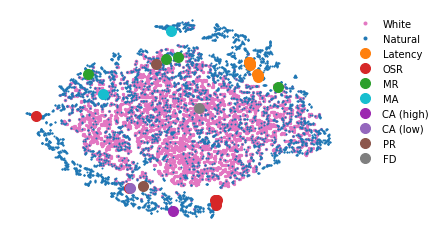

In [280]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.scatter(Y[len_peaks:w_end,0], Y[n_end:w_end,1], color=plt.cm.tab10(6), s=5, label='White', zorder=1)
plt.scatter(Y[:n_end,0], Y[:n_end,1], color=plt.cm.tab10(0), s=1, label='Natural', zorder=2)
plt.scatter(Y[w_end:latency_end,0], Y[w_end:latency_end,1], color=plt.cm.tab10(1), s=100, label='Latency', zorder=3)
plt.scatter(Y[latency_end:osr_end,0], Y[latency_end:osr_end,1], color=plt.cm.tab10(3), s=100, label='OSR', zorder=4)
plt.scatter(Y[osr_end:mr_end,0], Y[osr_end:mr_end,1], color=plt.cm.tab10(2), s=100, label='MR', zorder=5)
plt.scatter(Y[mr_end:ma_end,0], Y[mr_end:ma_end,1], color=plt.cm.tab10(9), s=100, label='MA', zorder=6)
plt.scatter(Y[ma_end:ma_end+1,0], Y[ma_end:ma_end+1,1], color='#9C27B0', s=100, alpha=1, label='CA (high)', zorder=7)
plt.scatter(Y[ma_end+1:ca_end,0], Y[ma_end+1:ca_end,1], color=plt.cm.tab10(4), s=100, alpha=1, label='CA (low)', zorder=8)
#plt.scatter(Y[ma_end:ca_end,0], Y[ma_end:ca_end,1], color=plt.cm.tab10(4), s=100, label='CA', zorder=7)
plt.scatter(Y[ca_end:pr_end,0], Y[ca_end:pr_end,1], color=plt.cm.tab10(5), s=100, label='PR', zorder=9)
plt.scatter(Y[pr_end:fd_end,0], Y[pr_end:fd_end,1], color=plt.cm.tab10(7), s=100, label='FD', zorder=10)


# Create custom legend handles with desired marker sizes
white_handle = mlines.Line2D([], [], color=plt.cm.tab10(6), marker='o', markersize=3, label='White', linestyle='None')
natural_handle = mlines.Line2D([], [], color=plt.cm.tab10(0), marker='o', markersize=3, label='Natural', linestyle='None')
latency_handle = mlines.Line2D([], [], color=plt.cm.tab10(1), marker='o', markersize=10, label='Latency', linestyle='None')
osr_handle = mlines.Line2D([], [], color=plt.cm.tab10(3), marker='o', markersize=10, label='OSR', linestyle='None')
mr_handle = mlines.Line2D([], [], color=plt.cm.tab10(2), marker='o', markersize=10, label='MR', linestyle='None')
ma_handle = mlines.Line2D([], [], color=plt.cm.tab10(9), marker='o', markersize=10, label='MA', linestyle='None')
ca_high_handle = mlines.Line2D([], [],  color='#9C27B0', marker='o', markersize=10, alpha=1, label='CA (high)', linestyle='None')
ca_low_handle = mlines.Line2D([], [], color=plt.cm.tab10(4), marker='o', markersize=10, label='CA (low)', linestyle='None')
pr_handle = mlines.Line2D([], [], color=plt.cm.tab10(5), marker='o', markersize=10, label='PR', linestyle='None')
fd_handle = mlines.Line2D([], [], color=plt.cm.tab10(7), marker='o', markersize=10, label='FD', linestyle='None')

# Adjust legend position and make the box transparent
plt.legend(handles=[white_handle, natural_handle, latency_handle, osr_handle, mr_handle, ma_handle, ca_high_handle, ca_low_handle, pr_handle, fd_handle], loc='upper left', bbox_to_anchor=(1, 1), framealpha=0)

# Make the box surrounding the plot transparent
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove ticks and scales
ax.set_xticks([])
ax.set_yticks([])

# Save the figure with adjusted dimensions and layout
plt.savefig('./Journal_Figures/tSNE_natural_white.pdf', bbox_inches='tight', pad_inches=0.5)


In [43]:
from scipy.fftpack import fft, fftshift, fftfreq
import torch # Add this import

def freq_doubling(predict, ncells, phases, widths, halfperiod=25, nsamples=140, filt_depth=40):
    F1 = np.zeros((ncells, phases.size, widths.size))
    F2 = np.zeros_like(F1)

    period = (2 * halfperiod) * 0.01
    base_freq = 1 / period
    freqs = fftfreq(nsamples - filt_depth, 0.01)
    i1 = np.where(freqs == base_freq)[0][0]
    i2 = np.where(freqs == base_freq * 2)[0][0]

    for p, phase in enumerate(phases):
        for w, width in tqdm(list(enumerate(widths))):
            X = tdrstim.reversing_grating(nsamples, halfperiod, width,
                                                    phase, 'sin')
            stim = tdrstim.concat(X)
            # Convert numpy array to PyTorch tensor
            model_device = next(predict.parameters()).device # Get the device of the model's weights
            stim_tensor = torch.from_numpy(stim).float().to(model_device) # Move tensor to the same device as the model's weights
            r = predict(stim_tensor) # Pass tensor instead of numpy array
            for ci in range(r.shape[1]):
                r_numpy = r[:, ci].detach().cpu().numpy() # Convert tensor to numpy array
                amp = np.abs(fft(r_numpy))
                F1[ci, p, w] = amp[i1]
                F2[ci, p, w] = amp[i2]
    return F1, F2, X, stim

phases = np.linspace(0, 1, 9)       # Grating phases.
widths = np.arange(1, 9)            # Bar widths (checkers).
F1, F2, X, stim = freq_doubling(model_n, ncells=17, phases=phases, widths=widths, halfperiod=25, nsamples=140, filt_depth=40)

intg, resp = tdrutils.integrated_gradient(model=model_n, X=stim, layer="sequential.0", chans=6, alpha_steps=100)


100%|██████████| 8/8 [00:00<00:00, 46.46it/s]

In [12]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

nk = 4
kmeans = KMeans(n_clusters=nk, random_state=0).fit(X)
#plt.scatter(Y[:,0], Y[:,1], c=kmeans.labels_, cmap='Set1', s=0.5, vmin=0,vmax=8)

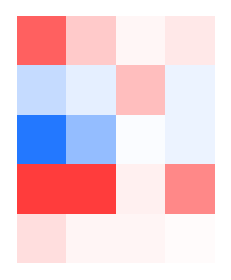

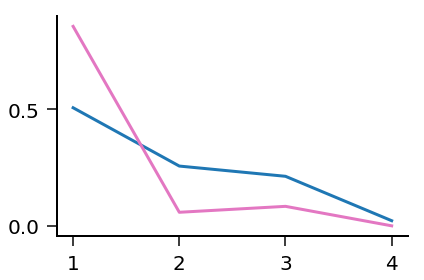

In [13]:
mode_freq_n = np.zeros(nk)
for i in range(nk):
    mode_freq_n[i] = (np.sum(kmeans.labels_[:n_end]==i))
    
mode_freq_w = np.zeros(nk)
for i in range(nk):
    mode_freq_w[i] = (np.sum(kmeans.labels_[n_end:w_end]==i))
    
modes = np.zeros([nk,X.shape[1]])
for i, c in enumerate(np.argsort(mode_freq_n)):
    modes[i] = np.mean(X[kmeans.labels_==c],axis=0)
    
    
ax = plt.subplot(111)   
#Set line width of axes
ax.spines["top"].set_linewidth(0)    
ax.spines["bottom"].set_linewidth(0)    
ax.spines["right"].set_linewidth(0)    
ax.spines["left"].set_linewidth(0) 
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
labelbottom="off", left="off", right="off", labelleft="off",direction='out',length=10,width=1.5,pad=8,labelsize=20)


plt.imshow(modes.T, cmap=mycmap, vmin=-1, vmax=1)#, extent=[x[0],x[-1],8,0],aspect=0.027)
plt.tight_layout()
#plt.savefig('./Journal_Figures/Modes.pdf')
plt.show()

ax = plt.subplot(111)   
#Set line width of axes
ax.spines["top"].set_linewidth(0)    
ax.spines["bottom"].set_linewidth(2)    
ax.spines["right"].set_linewidth(0)    
ax.spines["left"].set_linewidth(2) 
ax.tick_params(axis="both", which="both", bottom="on", top="off",    
labelbottom="on", left="on", right="off", labelleft="on",direction='out',length=10,width=1.5,pad=8,labelsize=20)
plt.yticks(np.arange(0.0, 1.1, step=0.5))

plt.plot(np.arange(1,5),mode_freq_n[np.argsort(mode_freq_n)[::-1]]/np.sum(mode_freq_n), lw=3, c=plt.cm.tab10(0))
plt.plot(np.arange(1,5),mode_freq_w[np.argsort(mode_freq_n)[::-1]]/np.sum(mode_freq_n), lw=3, c=plt.cm.tab10(6))
plt.tight_layout()
#plt.savefig('./Journal_Figures/Mode_frequency.pdf')